In [1]:
import pandas, numpy

In [2]:
import scipy, scipy.stats

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*(2/3), 9*(2/3)), 
                            'axes.labelsize':20
                           })

# user-defined variables

In [4]:
input_file = 'Seahorse_on_HLMVEC_Dec_2nd.xlsx'

# read information

In [5]:
df = pandas.read_excel(input_file, sheet_name='Rate')
df

,Measurement,Well,Group,Time,OCR,ECAR,PER
0,1,A01,Background,1.309773,0.0,0.0,0
1,1,A02,Background,1.309773,0.0,0.0,0
2,1,A03,Background,1.309773,0.0,0.0,0
3,1,A04,Background,1.309773,0.0,0.0,0
4,1,A05,Background,1.309773,0.0,0.0,0
...,...,...,...,...,...,...,...
1435,15,H08,Background,91.908998,0.0,0.0,0
1436,15,H09,Background,91.908998,0.0,0.0,0
1437,15,H10,Background,91.908998,0.0,0.0,0
1438,15,H11,Background,91.908998,0.0,0.0,0


In [6]:
df['Group'].unique()

array(['Background', 'Control', '24 HRS - Adreanline:Noradrenaline 5 uM',
       '24 HRS - Adreanline:Noradrenaline 0.5 uM', '24 HRS - Tnfa',
       '4 HRS - Adreanline:Noradrenaline 5 uM',
       '4 HRS - Adreanline:Noradrenaline 0.5 uM', '4 HRS - Tnfa'],
      dtype=object)

# OCR at four hours

Control
	 before normalization


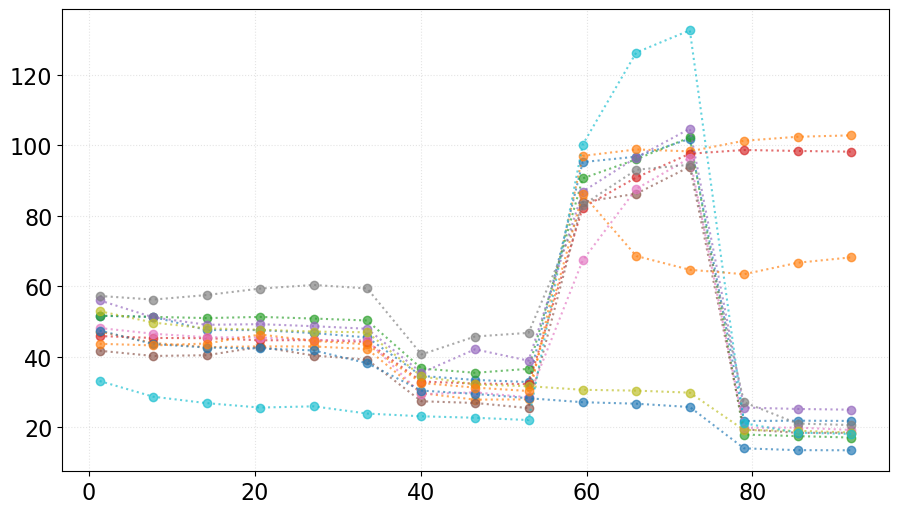

	 after excluding technical failures


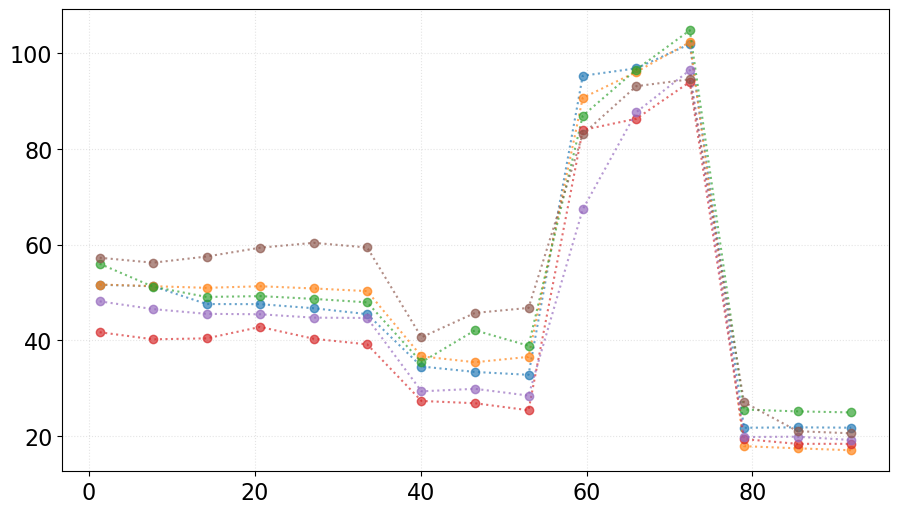

B02    1.016296
C02    1.024606
D02    1.059785
D11    0.873264
E02    0.911857
E11    1.114192
dtype: float64
	 after normalization


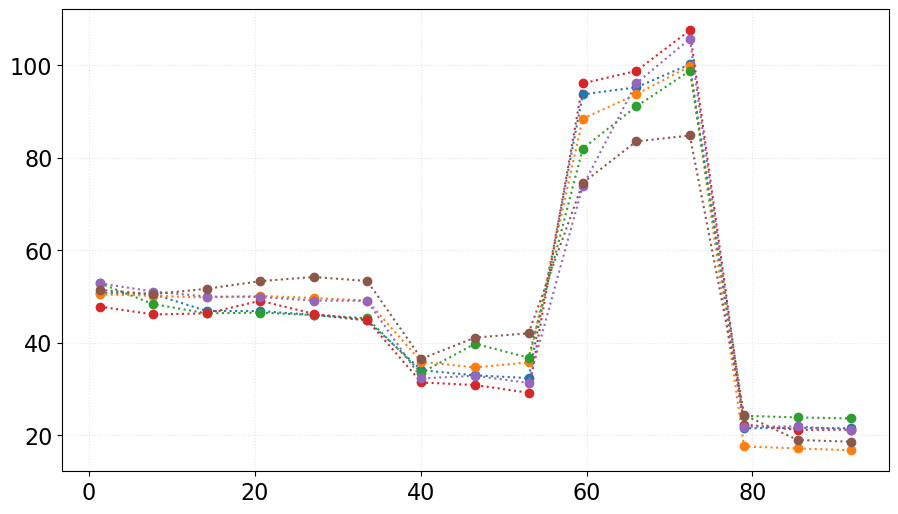

4 HRS - Adreanline:Noradrenaline 0.5 uM
	 before normalization


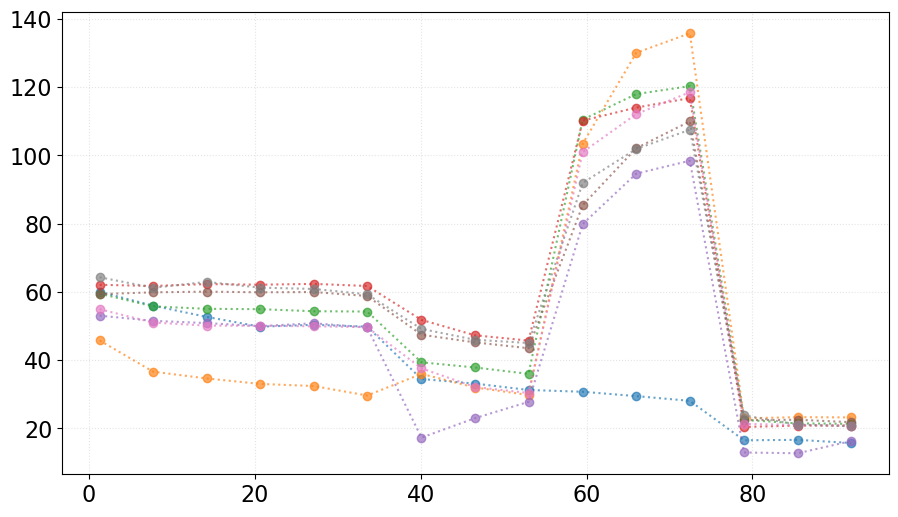

	 after excluding technical failures


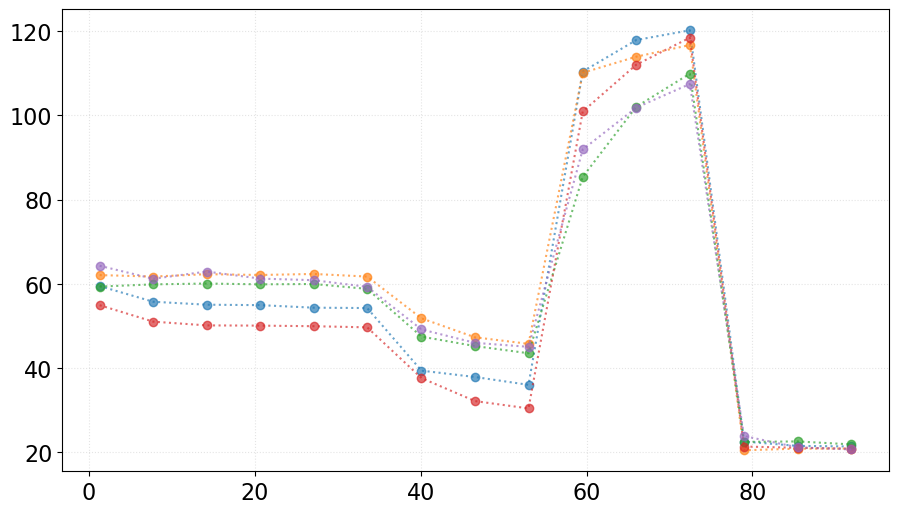

F05    0.997238
F06    1.065720
F08    0.994196
F09    0.927224
F10    1.015622
dtype: float64
	 after normalization


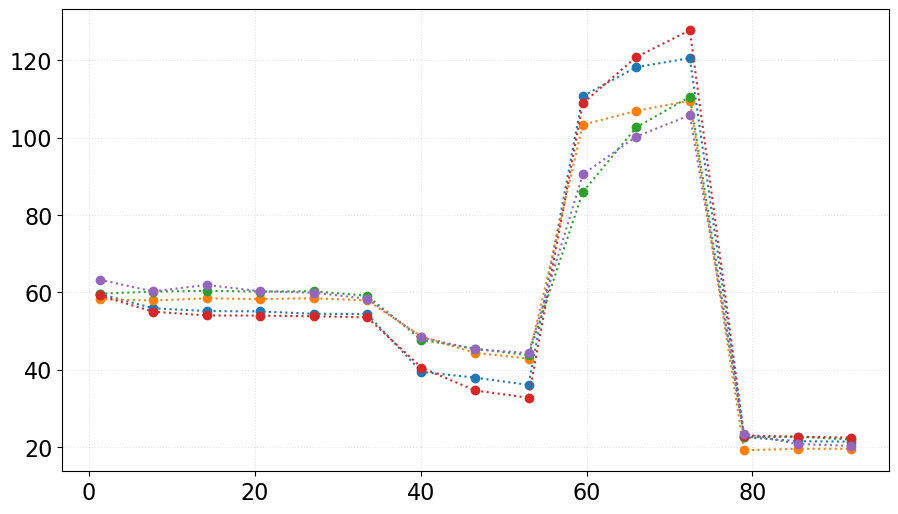

4 HRS - Adreanline:Noradrenaline 5 uM
	 before normalization


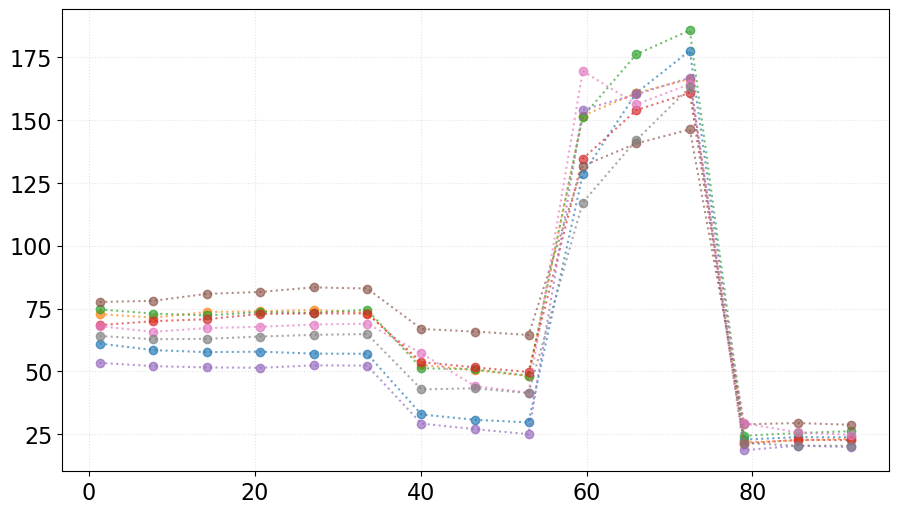

	 after excluding technical failures


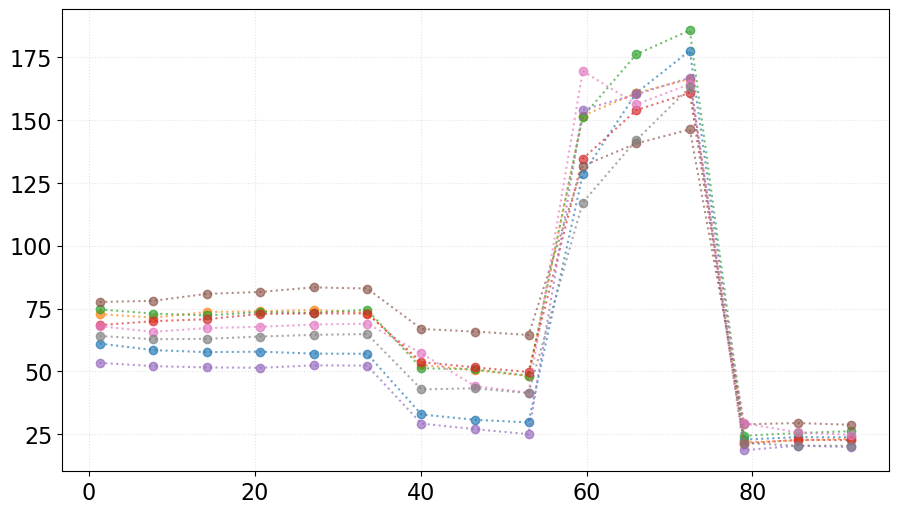

E03    0.907808
E04    1.053753
E05    1.094270
E06    1.018633
E07    0.866029
E08    1.100449
E09    1.036948
E10    0.922110
dtype: float64
	 after normalization


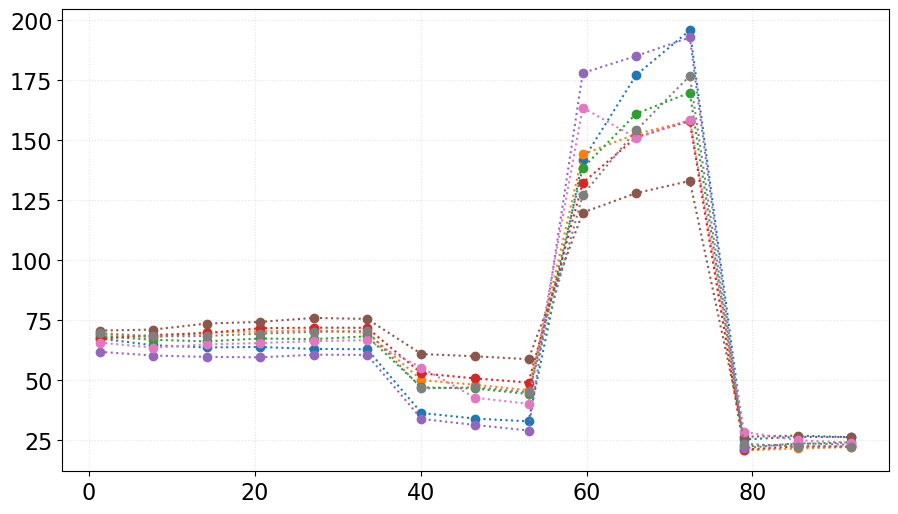

In [7]:
working_groups = ['Control', '4 HRS - Adreanline:Noradrenaline 0.5 uM', '4 HRS - Adreanline:Noradrenaline 5 uM']

excluded_wells = {}
excluded_wells['Control'] = ['F11', 'B11', 'C11', 'G11', 'F02', 'G02']
excluded_wells['4 HRS - Adreanline:Noradrenaline 0.5 uM'] = ['F03', 'F07', 'F04']
excluded_wells['4 HRS - Adreanline:Noradrenaline 5 uM'] = []

treated_trajectories = {}

for condition in working_groups:
    
    print(condition)
    sub = df[df['Group'] == condition]

    # generate dataframe for this trajectory
    dff = pandas.DataFrame()
    wells = sub['Well'].unique()
    for well in wells:
        trajectory = sub[sub['Well'] == well][['Time', 'OCR']]
        trajectory.set_index('Time', inplace=True)
        trajectory.rename(columns={'OCR': well}, inplace=True)
        dff[well] = trajectory[well]

    # plot original data
    print('\t before normalization')
    matplotlib.pyplot.plot(dff.index, dff, 'o:', alpha=2/3)
    matplotlib.pyplot.grid(ls=':', alpha=1/3)
    matplotlib.pyplot.show()

    # exclude samples that failed technically
    dff.drop(excluded_wells[condition], axis='columns', inplace=True)

    # plot after excluding technical failures
    print('\t after excluding technical failures')
    matplotlib.pyplot.plot(dff.index, dff, 'o:', alpha=2/3)
    matplotlib.pyplot.grid(ls=':', alpha=1/3)
    matplotlib.pyplot.show()

    # normalization
    relative_mu = dff.mean()/dff.mean().mean()
    print(relative_mu)
    normalized = dff/relative_mu

    # plot after normalization
    print('\t after normalization')
    matplotlib.pyplot.plot(dff.index, normalized, 'o:')
    matplotlib.pyplot.grid(ls=':', alpha=1/3)
    matplotlib.pyplot.show()

    # adding the treated data into container
    treated_trajectories[condition] = normalized

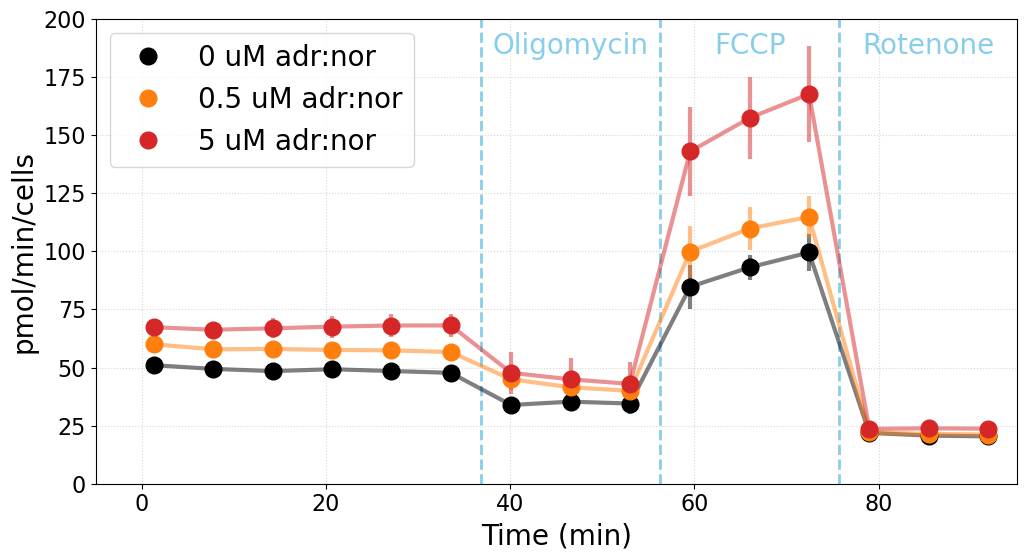

In [8]:
# genarate final figure

palette = ['black', 'tab:orange', 'tab:red']
my_labels = ['0 uM adr:nor', '0.5 uM adr:nor', '5 uM adr:nor']

respirations = []

for i in range(len(working_groups)):

    condition = working_groups[i]
    wdf = treated_trajectories[condition]

    mean = wdf.mean(axis=1)
    std = wdf.std(axis=1)
    t = wdf.index
    matplotlib.pyplot.errorbar(t, mean, std, lw=3, color=palette[i], alpha=1/2)
    matplotlib.pyplot.plot(t, mean, 'o', color=palette[i], ms=12, label=my_labels[i], zorder=999)

    plato_a = mean.iloc[:6].values
    plato_b = mean.iloc[6:9].values
    plato_c = mean.iloc[9:12].values
    plato_d = mean.iloc[12:15].values

    container = {}
    container['non-mito respiration'] = plato_d 
    container['basal respiration'] = plato_a - numpy.median(container['non-mito respiration'])
    container['proton leak'] = plato_b - numpy.median(container['non-mito respiration'])
    container['max resp cap'] = plato_c - numpy.median(container['non-mito respiration'])
    container['atp respiration'] = plato_a - numpy.median(plato_b)
    container['reserve capacity'] = plato_c - numpy.median(plato_a)
    respirations.append(container)    

l1 = numpy.mean([t[5], t[6]])
l2 = numpy.mean([t[8], t[9]])
l3 = numpy.mean([t[11], t[12]])
matplotlib.pyplot.axvline(x=l1, ls='--', lw=2, color='skyblue', zorder=1)
matplotlib.pyplot.axvline(x=l2, ls='--', lw=2, color='skyblue', zorder=1)
matplotlib.pyplot.axvline(x=l3, ls='--', lw=2, color='skyblue', zorder=1)

c1 = numpy.mean([l1, l2])
c2 = numpy.mean([l2, l3])
c3 = numpy.mean([l3, 95])
matplotlib.pyplot.text(c1, 185, 'Oligomycin', color='skyblue', horizontalalignment='center')
matplotlib.pyplot.text(c2, 185, 'FCCP', color='skyblue', horizontalalignment='center')
matplotlib.pyplot.text(c3, 185, 'Rotenone', color='skyblue', horizontalalignment='center')

matplotlib.pyplot.xlim([-5, 95])
matplotlib.pyplot.ylim([0, 200])

matplotlib.pyplot.xlabel('Time (min)')
matplotlib.pyplot.ylabel('pmol/min/cells')

matplotlib.pyplot.legend(loc=2)

matplotlib.pyplot.grid(ls=':', alpha=1/2)
matplotlib.pyplot.tight_layout()

#matplotlib.pyplot.show()
matplotlib.pyplot.savefig('seahorse.ocr.4h.svg')

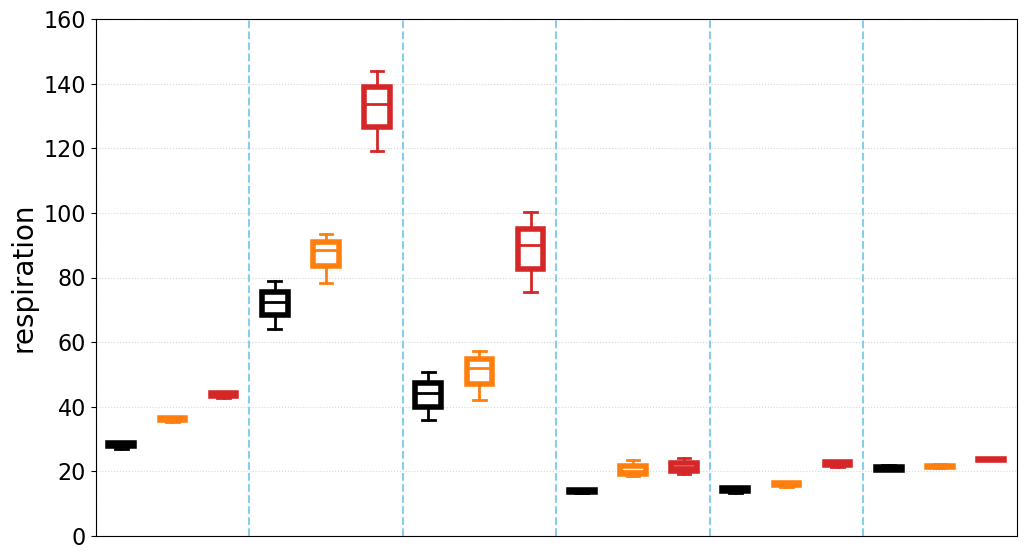

In [9]:
a = [respirations[i]['non-mito respiration'] for i in range(3)]
b = [respirations[i]['basal respiration'] for i in range(3)]
c = [respirations[i]['proton leak'] for i in range(3)]
d = [respirations[i]['max resp cap'] for i in range(3)]
e = [respirations[i]['atp respiration'] for i in range(3)]
f = [respirations[i]['reserve capacity'] for i in range(3)]
full = b + d + f + c + e + a

colors = ['black', 'tab:orange', 'tab:red'] * 6

bplot = matplotlib.pyplot.boxplot(full,
                                  showfliers=False,
                                  patch_artist=True, 
                                  medianprops={'color':'black', 'linewidth':2},
                                  boxprops={'linewidth':4}, 
                                  whiskerprops={'linewidth':2},
                                  capprops={'linewidth':2})

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor('white')
    patch.set_edgecolor(color)

for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)

for i in range(len(bplot['whiskers'])):    
    index = int(numpy.floor(i/2))
    color = colors[index]
    bplot['whiskers'][i].set_color(color)
    bplot['caps'][i].set_color(color)

for i in range(6):
    location = i*3 + 0.5
    matplotlib.pyplot.axvline(x=location, ls='--', color='skyblue')

matplotlib.pyplot.ylim([0, 160])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.grid(ls=':', alpha=0.5, axis='y')
matplotlib.pyplot.ylabel('respiration')
matplotlib.pyplot.tight_layout()

#matplotlib.pyplot.show()
matplotlib.pyplot.savefig('respiration.svg')

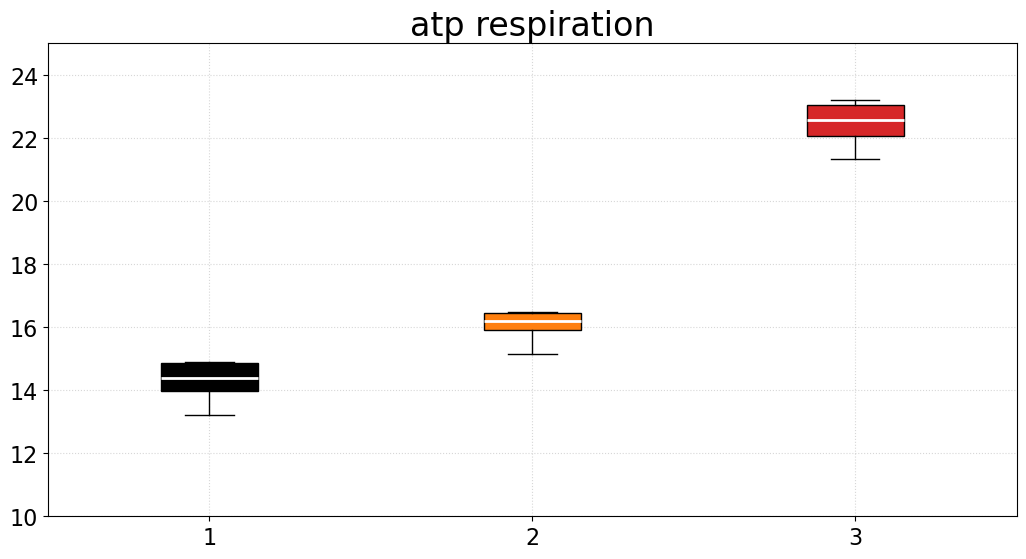

orange TtestResult(statistic=2.8103398472129766, pvalue=0.018464124164166974, df=10.0)
red TtestResult(statistic=14.428758846710727, pvalue=5.0745656143850394e-08, df=10.0)


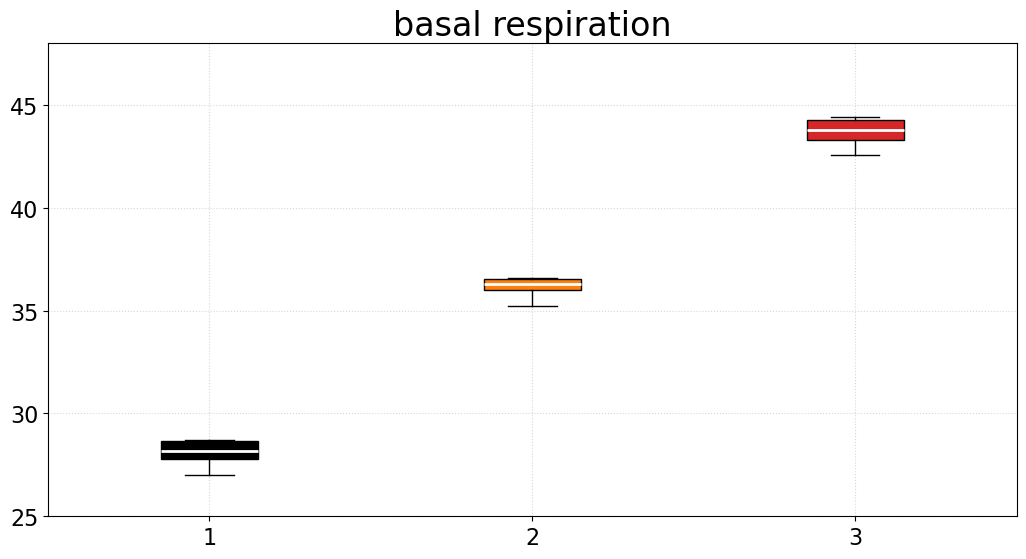

orange TtestResult(statistic=12.433639512119083, pvalue=2.0907755473736594e-07, df=10.0)
red TtestResult(statistic=27.973480663948664, pvalue=7.913294987864568e-11, df=10.0)


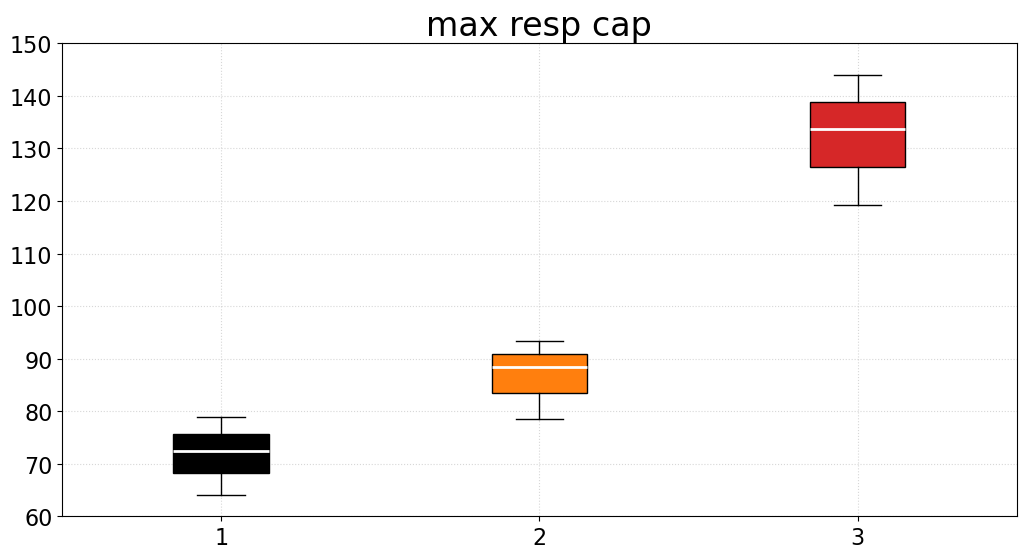

orange TtestResult(statistic=2.445210009013596, pvalue=0.07080965871103886, df=4.0)
red TtestResult(statistic=7.259860860936567, pvalue=0.0019116502796689488, df=4.0)


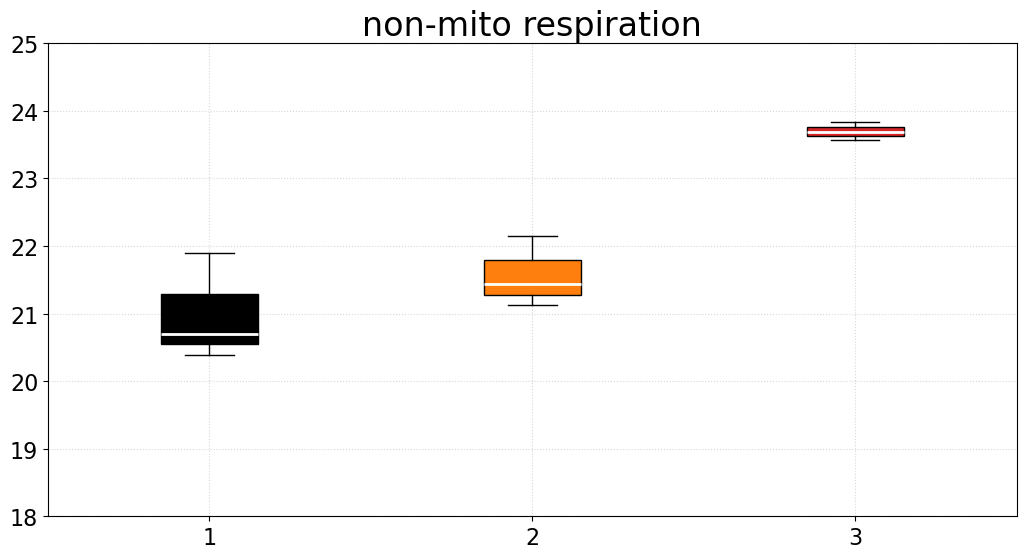

orange TtestResult(statistic=1.0485761341925965, pvalue=0.3535490985987199, df=4.0)
red TtestResult(statistic=5.825580567215799, pvalue=0.004324719512924679, df=4.0)


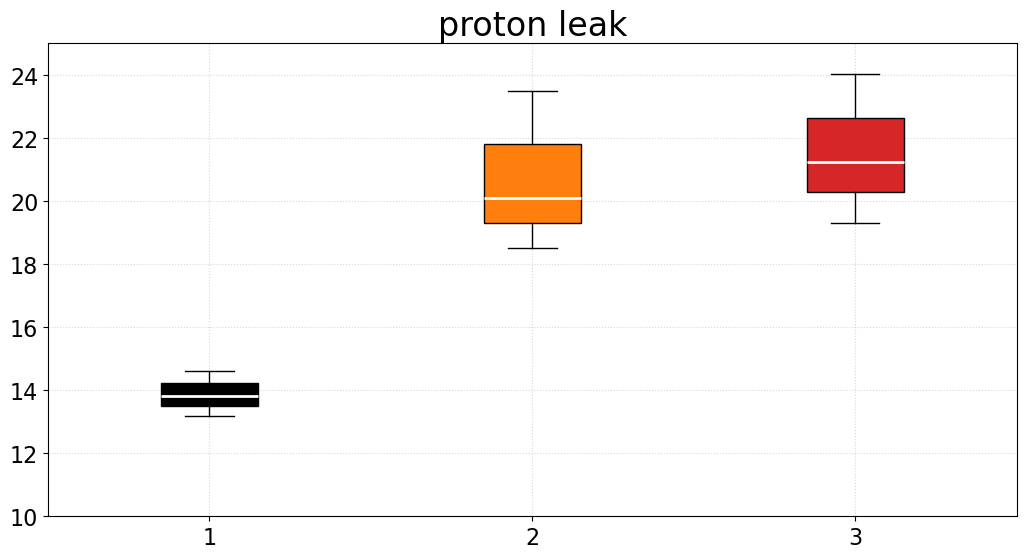

orange TtestResult(statistic=4.474434977773793, pvalue=0.011036960732113224, df=4.0)
red TtestResult(statistic=5.33253768984656, pvalue=0.005955086343678314, df=4.0)


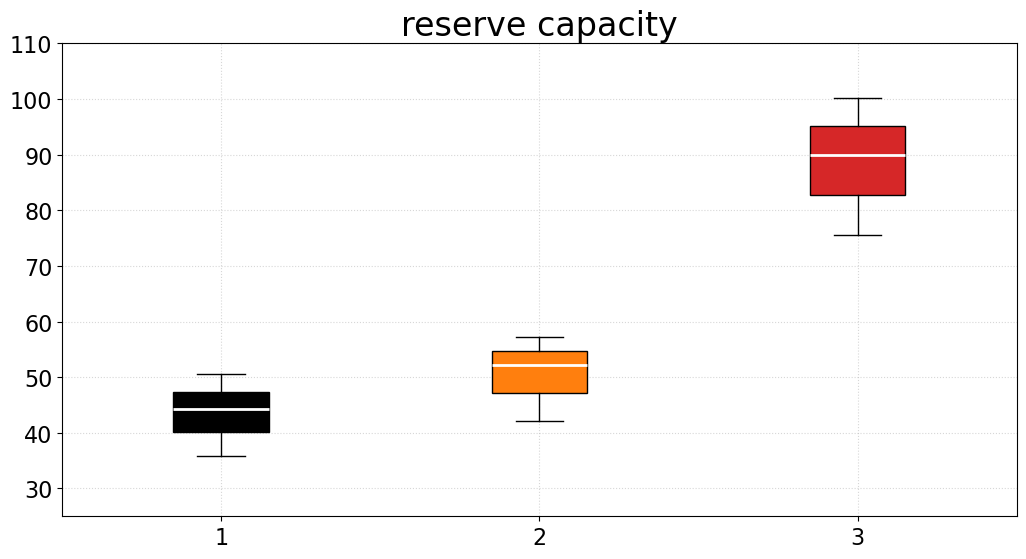

orange TtestResult(statistic=1.1255075230077574, pvalue=0.3233353838898822, df=4.0)
red TtestResult(statistic=5.388623470271248, pvalue=0.005735527699864795, df=4.0)


In [10]:
# statistics and extra plots
features = list(respirations[0].keys())
features.sort()
ylimits = [[10, 25], 
           [25, 48],
           [60, 150], 
           [18, 25],
           [10, 25], 
           [25, 110]
          ]

for i in range(len(features)):
    feature = features[i]
    local_ylim = ylimits[i]
    
    a = respirations[0][feature]
    b = respirations[1][feature]
    c = respirations[2][feature]
    bplot = matplotlib.pyplot.boxplot([a, b, c], 
                                      showfliers=False, 
                                      patch_artist=True, 
                                      medianprops={'color':'white', 'linewidth':2})
    colors = ['black', 'tab:orange', 'tab:red']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    matplotlib.pyplot.grid(ls=':', alpha=0.5)
    matplotlib.pyplot.title(feature)
    matplotlib.pyplot.ylim(local_ylim)
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

    result = scipy.stats.ttest_ind(b, a)
    print('orange', result)
    result = scipy.stats.ttest_ind(c, a)
    print('red', result)

# ECAR at 4 hours

In [11]:
df['Group'].unique()

array(['Background', 'Control', '24 HRS - Adreanline:Noradrenaline 5 uM',
       '24 HRS - Adreanline:Noradrenaline 0.5 uM', '24 HRS - Tnfa',
       '4 HRS - Adreanline:Noradrenaline 5 uM',
       '4 HRS - Adreanline:Noradrenaline 0.5 uM', '4 HRS - Tnfa'],
      dtype=object)

Control
	 before normalization


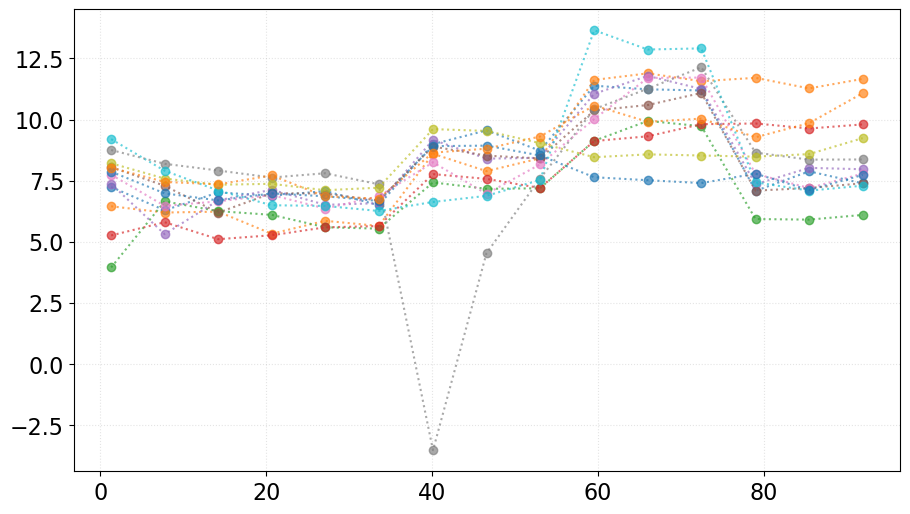

	 after excluding technical failures


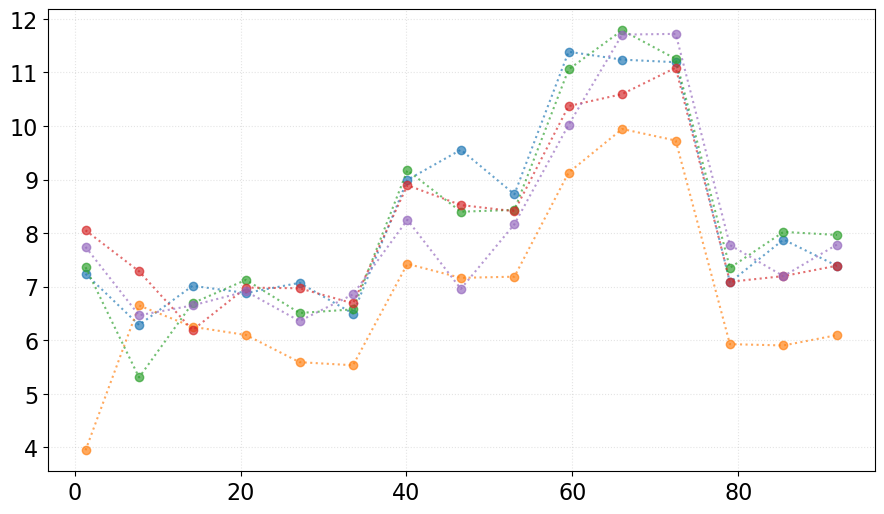

	 after normalization


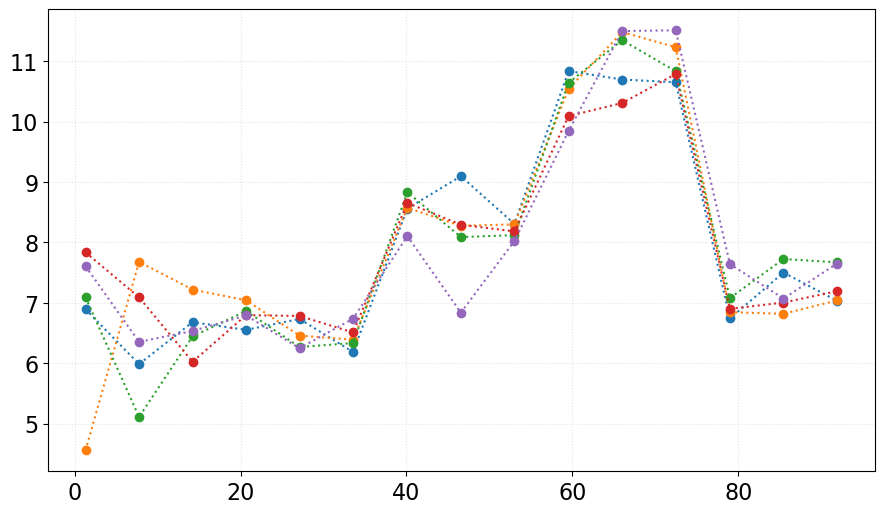

4 HRS - Adreanline:Noradrenaline 0.5 uM
	 before normalization


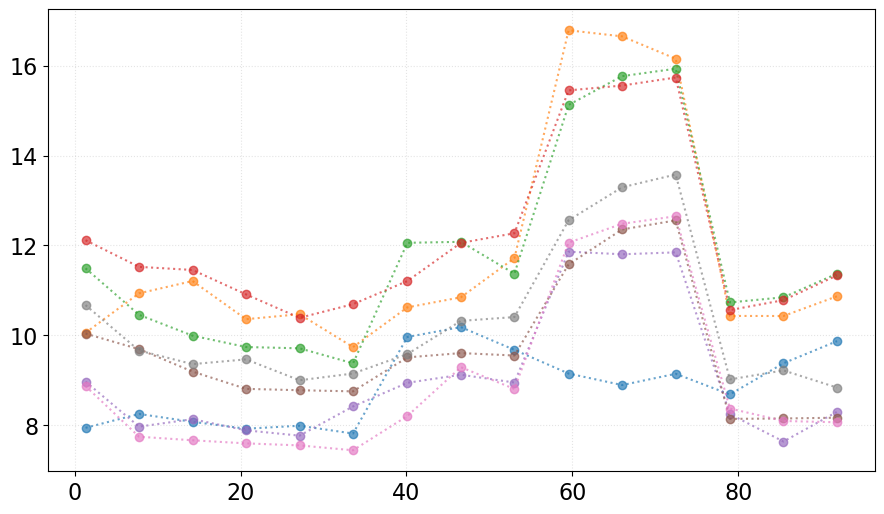

	 after excluding technical failures


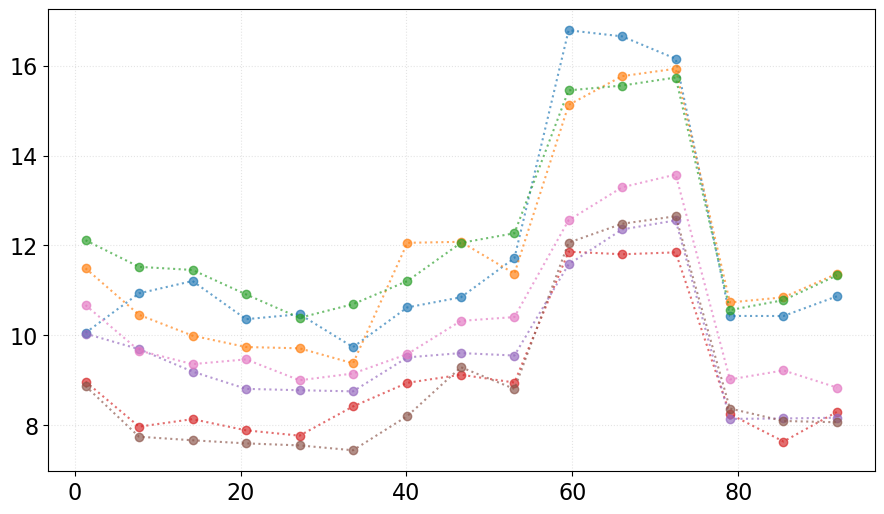

	 after normalization


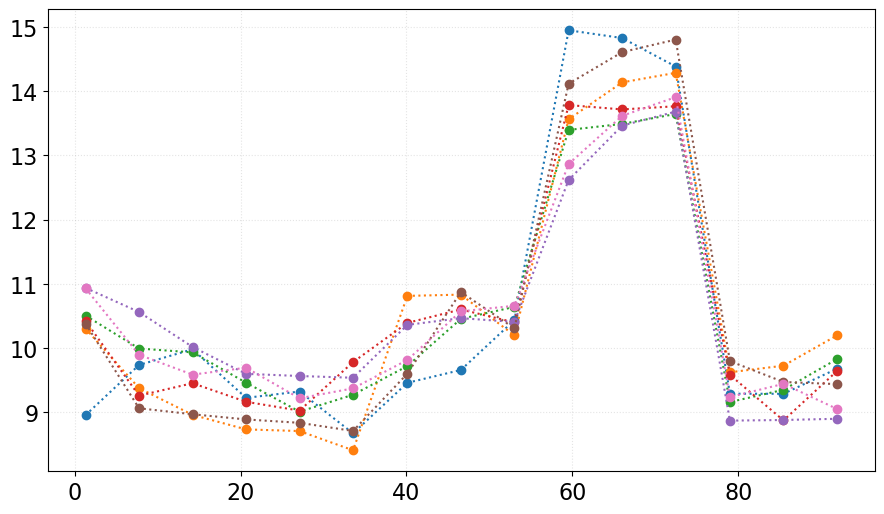

4 HRS - Adreanline:Noradrenaline 5 uM
	 before normalization


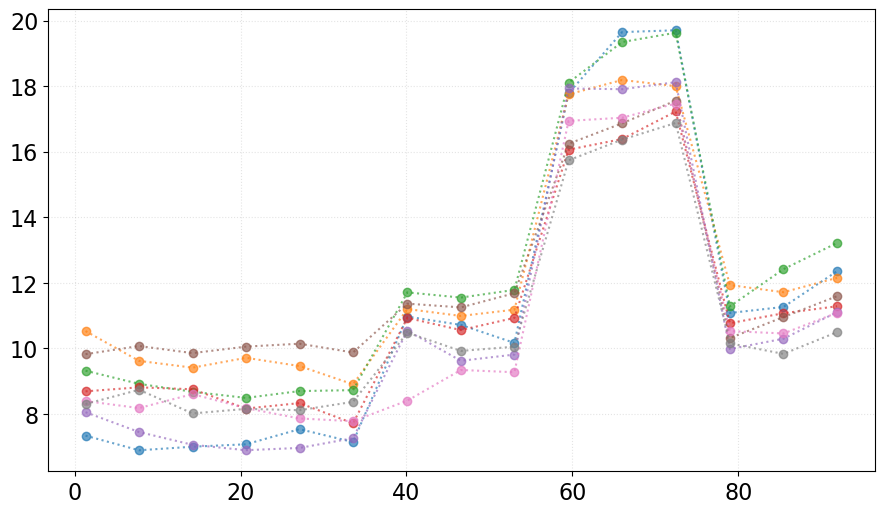

	 after excluding technical failures


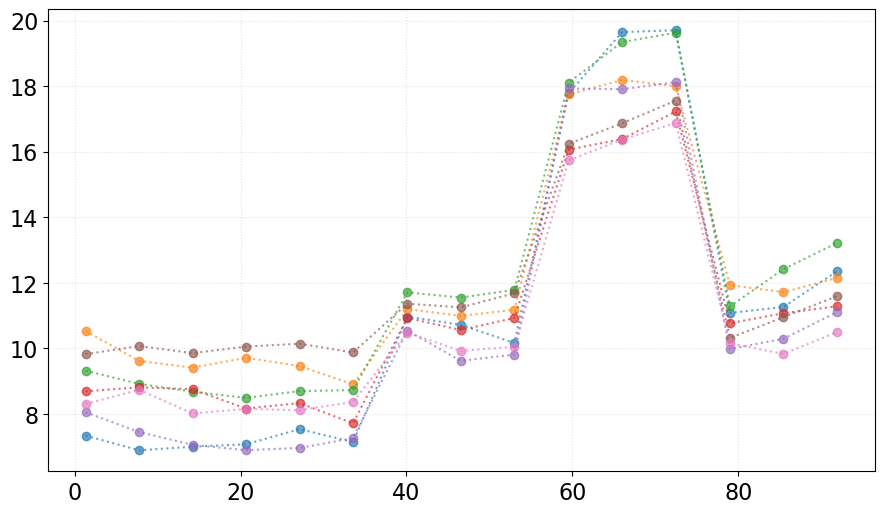

	 after normalization


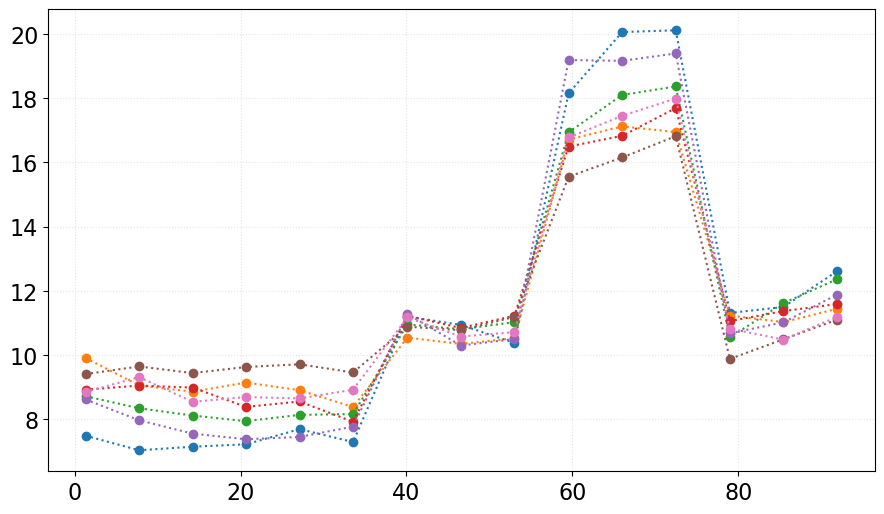

In [12]:
working_groups = ['Control', '4 HRS - Adreanline:Noradrenaline 0.5 uM', '4 HRS - Adreanline:Noradrenaline 5 uM']

excluded_wells = {}
excluded_wells['Control'] = ['E11', 'F11', 'F02', 'G02', 'B11', 'G11', 'C11']
excluded_wells['4 HRS - Adreanline:Noradrenaline 0.5 uM'] = ['F03']
excluded_wells['4 HRS - Adreanline:Noradrenaline 5 uM'] = ['E09']

treated_trajectories = {}

for condition in working_groups:
    
    print(condition)
    sub = df[df['Group'] == condition]

    # generate dataframe for this trajectory
    dff = pandas.DataFrame()
    wells = sub['Well'].unique()
    for well in wells:
        trajectory = sub[sub['Well'] == well][['Time', 'ECAR']]
        trajectory.set_index('Time', inplace=True)
        trajectory.rename(columns={'ECAR': well}, inplace=True)
        dff[well] = trajectory[well]

    # plot original data
    print('\t before normalization')
    matplotlib.pyplot.plot(dff.index, dff, 'o:', alpha=2/3)
    matplotlib.pyplot.grid(ls=':', alpha=1/3)
    matplotlib.pyplot.show()

    # exclude samples that failed technically
    dff.drop(excluded_wells[condition], axis='columns', inplace=True)

    # plot after excluding technical failures
    print('\t after excluding technical failures')
    matplotlib.pyplot.plot(dff.index, dff, 'o:', alpha=2/3)
    matplotlib.pyplot.grid(ls=':', alpha=1/3)
    matplotlib.pyplot.show()

    # normalization
    relative_mu = dff.mean()/dff.mean().mean()
    normalized = dff/relative_mu

    # normalization on initial state
    #inistate = dff.iloc[:6, :]
    #relative_mu = inistate.mean()/inistate.mean().mean()
    #normalized = dff/relative_mu

    # plot after normalization
    print('\t after normalization')
    matplotlib.pyplot.plot(dff.index, normalized, 'o:')
    matplotlib.pyplot.grid(ls=':', alpha=1/3)
    matplotlib.pyplot.show()

    # adding the treated data into container
    treated_trajectories[condition] = normalized

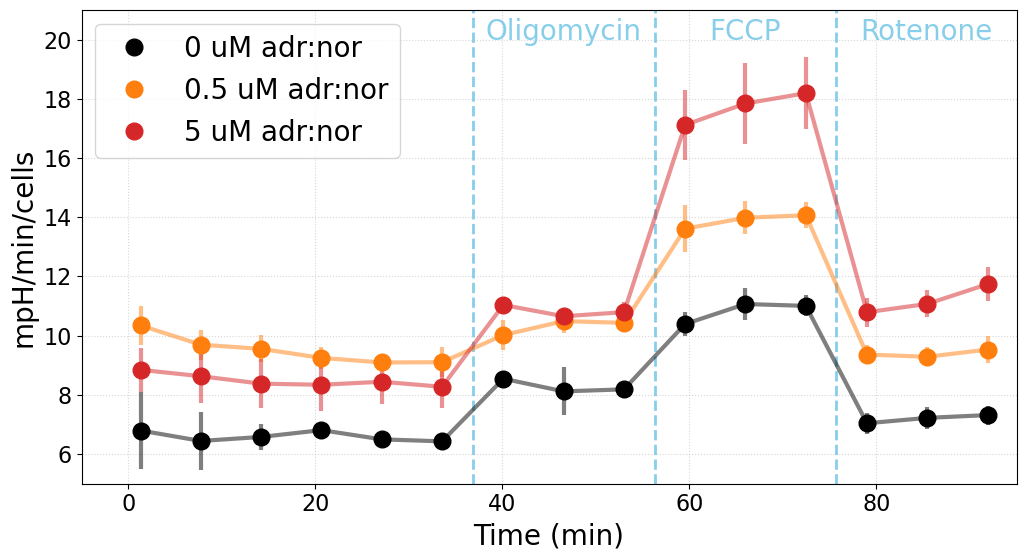

In [13]:
# genarate final figure

palette = ['black', 'tab:orange', 'tab:red']
my_labels = ['0 uM adr:nor', '0.5 uM adr:nor', '5 uM adr:nor']
glycos = []

for i in range(len(working_groups)):

    condition = working_groups[i]
    wdf = treated_trajectories[condition]

    mean = wdf.mean(axis=1)
    std = wdf.std(axis=1)
    t = wdf.index
    matplotlib.pyplot.errorbar(t, mean, std, lw=3, color=palette[i], alpha=1/2)
    matplotlib.pyplot.plot(t, mean, 'o', color=palette[i], ms=12, label=my_labels[i], zorder=999)

    plato_a = mean.iloc[:6].values
    #plato_b = mean.iloc[6:9].values
    plato_c = mean.iloc[9:12].values
    #plato_d = mean.iloc[12:15].values

    # defined by Ottar on 06.09.2024
    container = {}
    container['glycolysis'] = plato_a
    container['glycolytic capacity'] = plato_c - numpy.median(plato_a)
    glycos.append(container)    

l1 = numpy.mean([t[5], t[6]])
l2 = numpy.mean([t[8], t[9]])
l3 = numpy.mean([t[11], t[12]])
matplotlib.pyplot.axvline(x=l1, ls='--', lw=2, color='skyblue', zorder=1)
matplotlib.pyplot.axvline(x=l2, ls='--', lw=2, color='skyblue', zorder=1)
matplotlib.pyplot.axvline(x=l3, ls='--', lw=2, color='skyblue', zorder=1)

c1 = numpy.mean([l1, l2])
c2 = numpy.mean([l2, l3])
c3 = numpy.mean([l3, 95])
matplotlib.pyplot.text(c1, 20, 'Oligomycin', color='skyblue', horizontalalignment='center')
matplotlib.pyplot.text(c2, 20, 'FCCP', color='skyblue', horizontalalignment='center')
matplotlib.pyplot.text(c3, 20, 'Rotenone', color='skyblue', horizontalalignment='center')

matplotlib.pyplot.xlim([-5, 95])
matplotlib.pyplot.ylim([5, 21])

matplotlib.pyplot.xlabel('Time (min)')
matplotlib.pyplot.ylabel('mpH/min/cells')

matplotlib.pyplot.legend(loc=2)

matplotlib.pyplot.grid(ls=':', alpha=1/2)
matplotlib.pyplot.tight_layout()

#matplotlib.pyplot.show()
matplotlib.pyplot.savefig('seahorse.ecar.4h.svg')

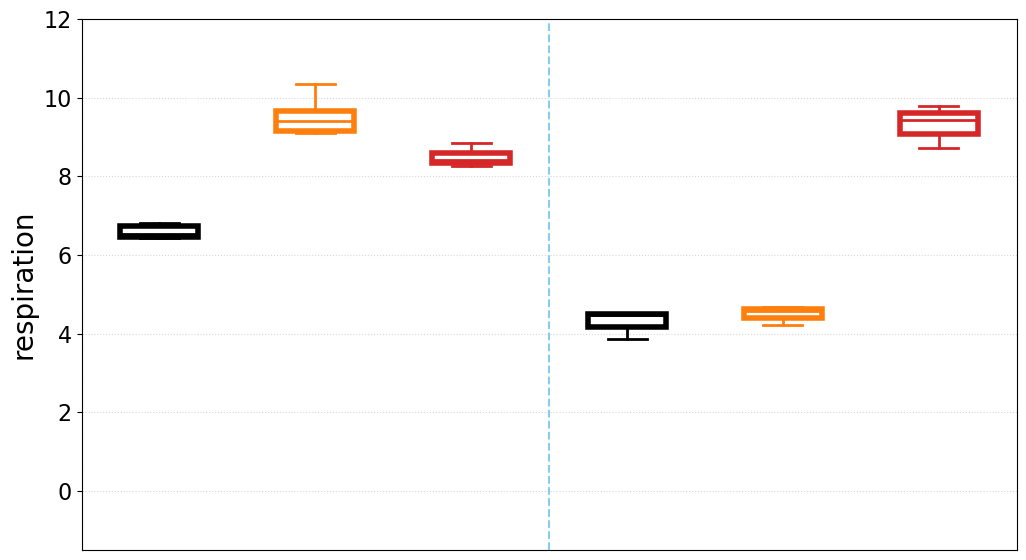

In [14]:
b = [glycos[i]['glycolysis'] for i in range(3)]
c = [glycos[i]['glycolytic capacity'] for i in range(3)]

full = b + c

colors = ['black', 'tab:orange', 'tab:red'] * 2

bplot = matplotlib.pyplot.boxplot(full,
                                  showfliers=False,
                                  patch_artist=True, 
                                  medianprops={'color':'black', 'linewidth':2},
                                  boxprops={'linewidth':4}, 
                                  whiskerprops={'linewidth':2},
                                  capprops={'linewidth':2})

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor('white')
    patch.set_edgecolor(color)

for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)

for i in range(len(bplot['whiskers'])):    
    index = int(numpy.floor(i/2))
    color = colors[index]
    bplot['whiskers'][i].set_color(color)
    bplot['caps'][i].set_color(color)

for i in range(2):
    location = i*3 + 0.5
    matplotlib.pyplot.axvline(x=location, ls='--', color='skyblue')

matplotlib.pyplot.ylim([-1.5, 12])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.grid(ls=':', alpha=0.5, axis='y')
matplotlib.pyplot.ylabel('respiration')
matplotlib.pyplot.tight_layout()

#matplotlib.pyplot.show()
matplotlib.pyplot.savefig('glyco.svg')

In [15]:
# statistics 
features = list(glycos[0].keys())
features.sort()

for i in range(len(features)):
    feature = features[i]
    print(feature)
    a = glycos[0][feature]
    b = glycos[1][feature]
    c = glycos[2][feature]

    print('\t', a, b)
    result = scipy.stats.ttest_ind(b, a)
    print('\t\t orange', result)
    print('\t', a, c)
    result = scipy.stats.ttest_ind(c, a)
    print('\t\t red', result)
    print()

glycolysis
	 [6.79716221 6.44431528 6.58072838 6.80954773 6.49834635 6.43148058] [10.34662619  9.69554044  9.55481292  9.24946077  9.09530649  9.10491707]
		 orange TtestResult(statistic=14.074339117058882, pvalue=6.438115307072991e-08, df=10.0)
	 [6.79716221 6.44431528 6.58072838 6.80954773 6.49834635 6.43148058] [8.84633401 8.63119537 8.37922815 8.34219745 8.44450848 8.27347391]
		 red TtestResult(statistic=16.910236955288603, pvalue=1.0994358874765121e-08, df=10.0)

glycolytic capacity
	 [3.85486623 4.5297906  4.46683283] [4.21257155 4.57985681 4.6674454 ]
		 orange TtestResult(statistic=0.7908865784391956, pvalue=0.47326191932504164, df=4.0)
	 [3.85486623 4.5297906  4.46683283] [8.70772242 9.43057397 9.77917507]
		 red TtestResult(statistic=13.148068782554539, pvalue=0.00019325826284603338, df=4.0)

